# Regression example with a neural network

## Prepare data

In [1]:
import pickle
import gzip
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
with gzip.open("rec_hist_pt_25.pkl.gz") as f:
    rec = pickle.load(f)

with gzip.open("gen_hist_pt_25.pkl.gz") as f:
    gen = pickle.load(f)

rec = rec[:,:,:,:,:]
gen = gen[:,:,:,:,:]
# fix for divide by zero
gen.values()[gen.values() == 0] = 1

n = gen.values()
ns = rec.values()
# fix for rec > n
ns = np.where(ns > n, n, ns)
nf = n - ns

eff = ns / n

# z = 1
# sigma_eff = z/(n + z ** 2) * np.sqrt(ns * nf / (n + 1e-8) + z ** 2 / 4)

X = []
y = []
for ieta, eta in enumerate(rec.axes[0].centers):
    for ipt, pt in enumerate(rec.axes[1].centers):
        for iphi, phi in enumerate(rec.axes[2].centers):
            for ich, _ in enumerate(rec.axes[3]):
                for isp, _ in enumerate(rec.axes[4]):
                    X.append((eta, np.log(pt), np.cos(phi), np.sin(phi), ich, isp))
                    y.append(eff[ieta, ipt, iphi, ich, isp])

X_raw = np.array(X).astype(np.float32)
y = np.array(y).astype(np.float32)

scaler = StandardScaler()
scaler.fit(X_raw)

X = scaler.transform(X_raw)

print("data points", X.shape[0])

data points 14400


## Scikit-Learn

It turns out that the simple MLPRegressor in Scikit-Learn works very well on small datasets.

In [3]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

clf = MLPRegressor(
    hidden_layer_sizes=(2**6,) * 5,
    batch_size=1000,
    alpha=0,
    tol=1e-6,
    max_iter=1000,
    verbose=1,
)

clf.fit(X, y)

# coefficients only available after training
n = 0
for c in clf.coefs_:
    n += np.prod(c.shape)
for c in clf.intercepts_:
    n += c.shape[0]
print("number of parameters", n)

print("MLPRegressor", mean_squared_error(clf.predict(X), y))

Iteration 1, loss = 0.04913882
Iteration 2, loss = 0.02083119
Iteration 3, loss = 0.01333213
Iteration 4, loss = 0.00865548
Iteration 5, loss = 0.00574320
Iteration 6, loss = 0.00424658
Iteration 7, loss = 0.00348542
Iteration 8, loss = 0.00299996
Iteration 9, loss = 0.00266674
Iteration 10, loss = 0.00238016
Iteration 11, loss = 0.00226747
Iteration 12, loss = 0.00209453
Iteration 13, loss = 0.00190363
Iteration 14, loss = 0.00173372
Iteration 15, loss = 0.00161904
Iteration 16, loss = 0.00155036
Iteration 17, loss = 0.00151437
Iteration 18, loss = 0.00139401
Iteration 19, loss = 0.00131589
Iteration 20, loss = 0.00127896
Iteration 21, loss = 0.00126018
Iteration 22, loss = 0.00117516
Iteration 23, loss = 0.00117033
Iteration 24, loss = 0.00111437
Iteration 25, loss = 0.00107260
Iteration 26, loss = 0.00102382
Iteration 27, loss = 0.00101455
Iteration 28, loss = 0.00097498
Iteration 29, loss = 0.00096536
Iteration 30, loss = 0.00092183
Iteration 31, loss = 0.00093335
Iteration 32, los

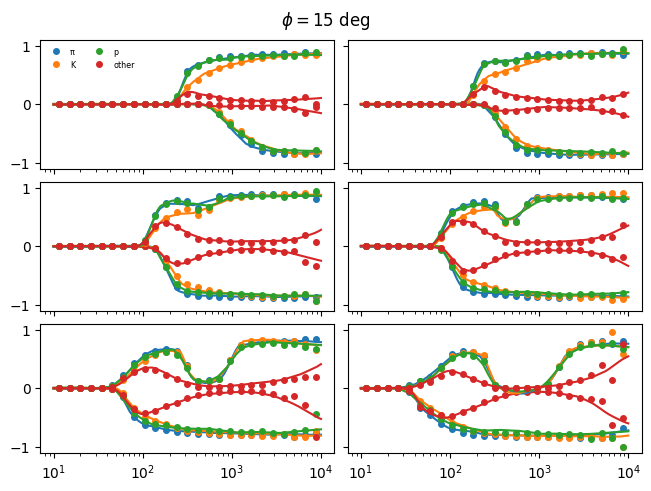

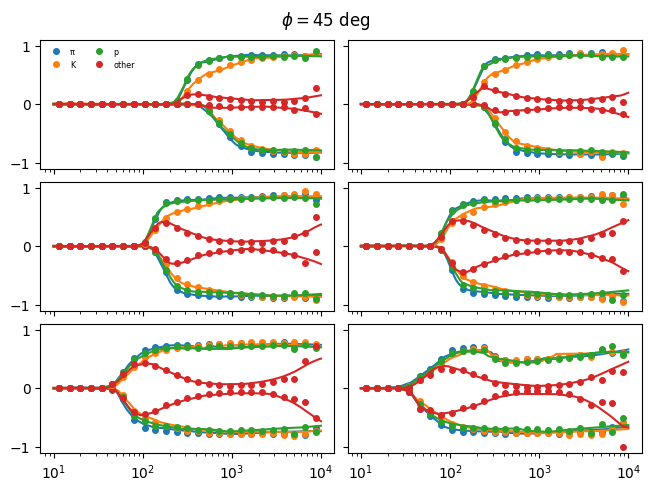

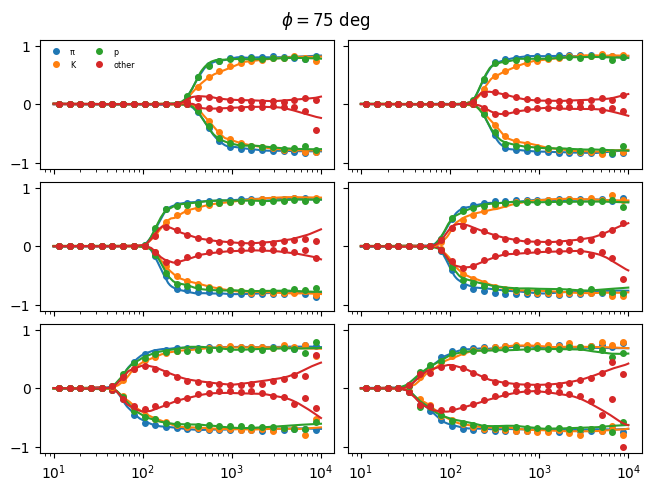

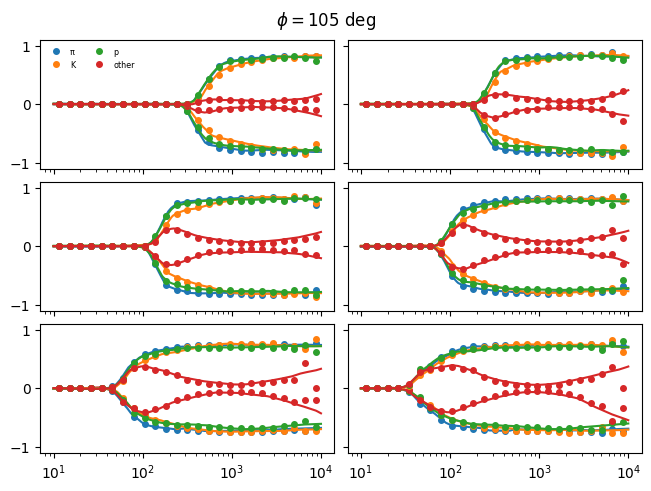

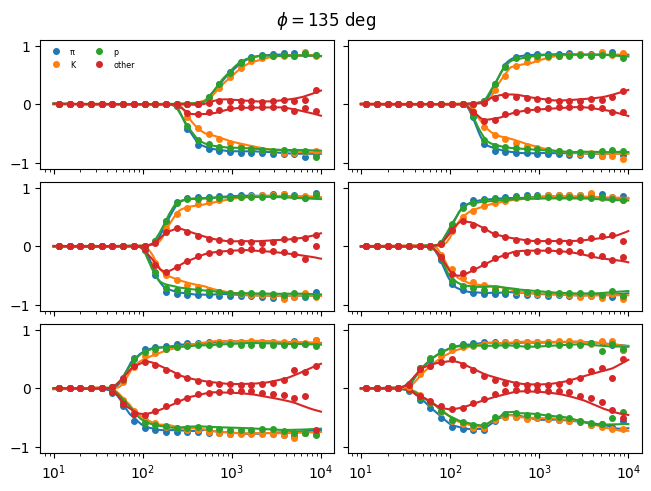

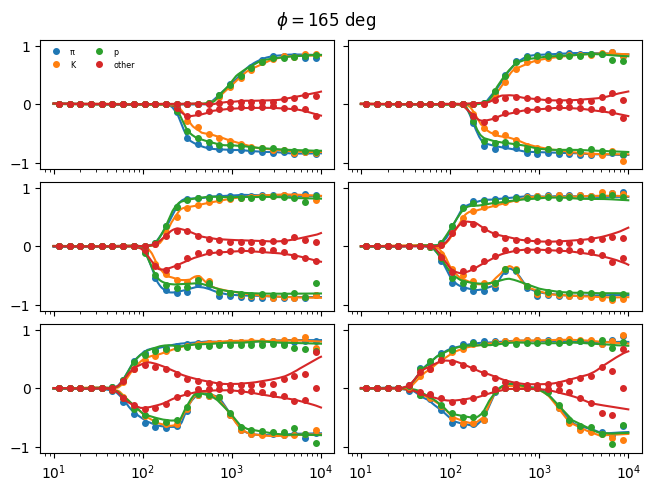

In [4]:
labels = ("π", "K", "p", "other")
for phii in rec.axes[2].centers[:]:
    if phii < 0:
        continue
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
    plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
    for etai, axi in zip(rec.axes[0].centers, axes.flat):
        plt.sca(axi)
        for ich, charge in enumerate((-1, 1)):
            for isp, label in enumerate(labels):
                ma = X_raw[:, 0] == etai
                ma &= X_raw[:, 2] == np.cos(phii)
                ma &= X_raw[:, 3] == np.sin(phii)
                ma &= X_raw[:, 4] == ich
                ma &= X_raw[:, 5] == isp
                plt.plot(np.exp(X_raw[ma, 1]), charge * y[ma], "o", ms=4, color=f"C{isp}", label=f"{label}" if ich else None)

                mpt = np.geomspace(10, 1e4, 2000)
                Xp = np.empty((len(mpt), 6), dtype=np.float32)
                Xp[:, 0] = etai
                Xp[:, 1] = np.log(mpt)
                Xp[:, 2] = np.cos(phii)
                Xp[:, 3] = np.sin(phii)
                Xp[:, 4] = ich
                Xp[:, 5] = isp
                yp = clf.predict(scaler.transform(Xp))
                plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
    plt.sca(axes[0,0])
    plt.semilogx()
    plt.ylim(-1.1, 1.1)
    plt.legend(fontsize="xx-small", ncol=2, frameon=False);


## PyTorch

number of parameters 12993
99 0.009944583289325237
199 0.004184260498732328
299 0.002745134988799691
399 0.001953695435076952
Epoch 00457: reducing learning rate of group 0 to 8.0000e-04.
499 0.0015628341352567077
599 0.001394544611684978
Epoch 00618: reducing learning rate of group 0 to 6.4000e-04.
699 0.0012784888967871666
799 0.001213375711813569
Epoch 00806: reducing learning rate of group 0 to 5.1200e-04.
899 0.0011516185477375984
999 0.0011090518673881888
Epoch 01050: reducing learning rate of group 0 to 4.0960e-04.
1099 0.001074204221367836
1199 0.0010447623208165169
1299 0.0010205971775576472
Epoch 01372: reducing learning rate of group 0 to 3.2768e-04.
1399 0.0009925191989168525
1499 0.000973041111137718
1599 0.000955123919993639
1699 0.0009378522518090904
Epoch 01708: reducing learning rate of group 0 to 2.6214e-04.
1799 0.0009231517324224114
1899 0.0009095441200770438
1999 0.0008965294691734016
Epoch 02098: reducing learning rate of group 0 to 2.0972e-04.
2099 0.000883223721

[]

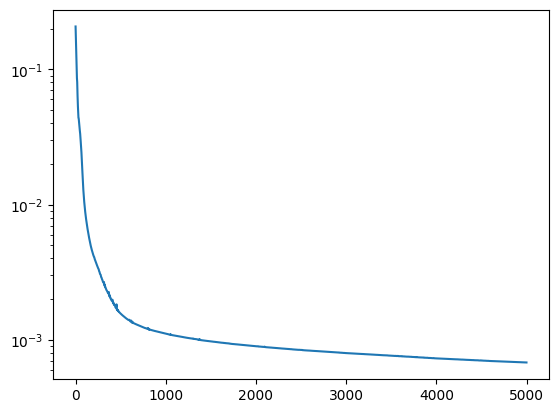

In [71]:
import torch
from torch import nn
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim import Adam

device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_device(device)
torch.set_default_dtype(torch.float32)

nonlin = nn.ReLU()
num = 2**6
torch_model = nn.Sequential(
    nn.Linear(6, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, num),
    nonlin,
    nn.Linear(num, 1),
    # adding a ReLU here makes training unstable
    nn.Flatten(0, 1),
)

n = 0
for par in torch_model.parameters():
    n += np.prod(par.shape)
print("number of parameters", n)

# must make copies here
torch_X = torch.tensor(X.copy())
torch_y = torch.tensor(y.copy())

max_epoch = 5000
shrink_patience = 10
abort_patience = 100
learning_rate = 1e-3
learning_rate_shrink_factor = 0.8
tol = 1e-6

loss_fn = nn.MSELoss()
opt = Adam(torch_model.parameters(), lr=learning_rate)
scheduler = ReduceLROnPlateau(
    opt, patience=shrink_patience, factor=learning_rate_shrink_factor, verbose=True
)

losses = []
no_improvement_below_tolerance = 0
prev_loss = np.inf
for epoch in range(max_epoch):
    y_pred = torch_model(torch_X)
    loss = loss_fn(y_pred, torch_y)
    opt.zero_grad()
    loss.backward()
    opt.step()
    scheduler.step(loss)

    loss = loss.item()
    losses.append(loss)
    if epoch % 100 == 99:
        print(epoch, loss)

    if loss < prev_loss - tol:
        no_improvement_below_tolerance = 0
        prev_loss = loss
    else:
        no_improvement_below_tolerance += 1
    if no_improvement_below_tolerance > abort_patience:
        break

plt.plot(losses)
plt.semilogy()

In [72]:
print("MLPRegressor", mean_squared_error(clf.predict(X), y))
print("PyTorch     ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))

MLPRegressor 0.0010236062
PyTorch      0.0006794772


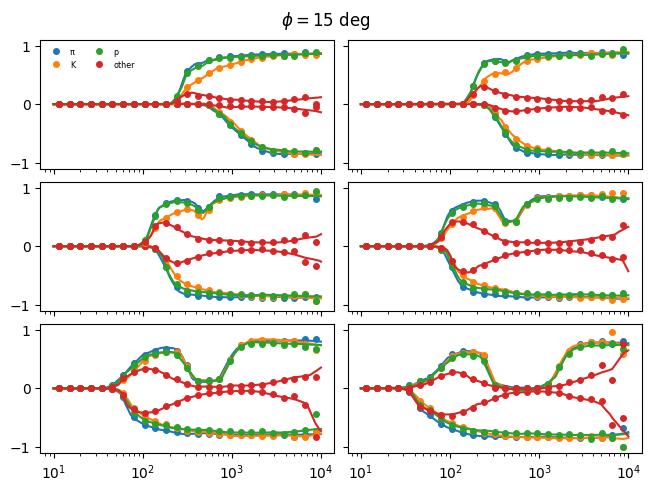

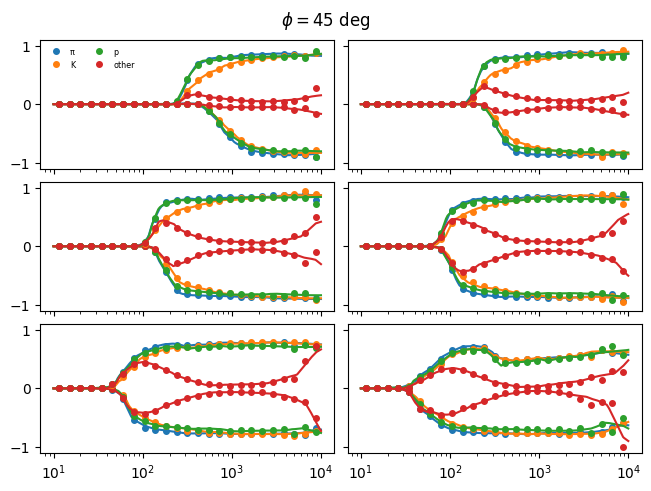

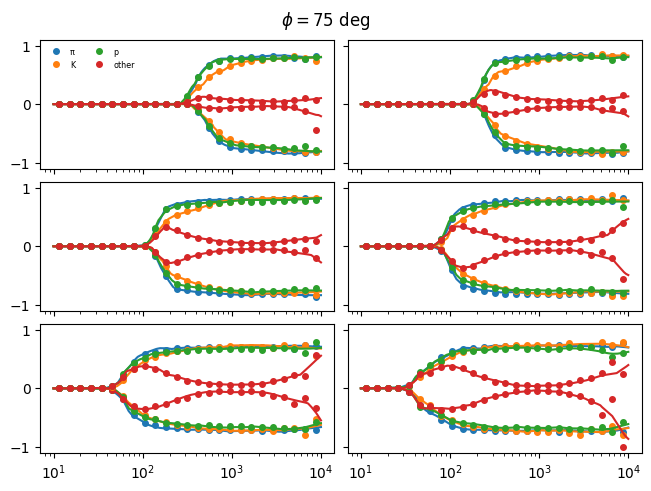

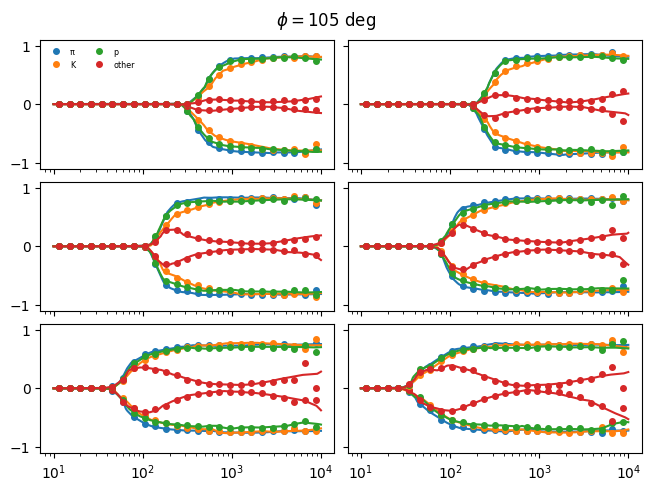

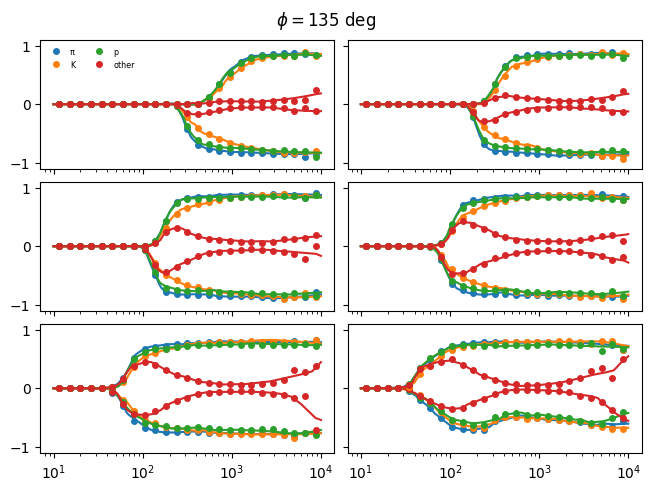

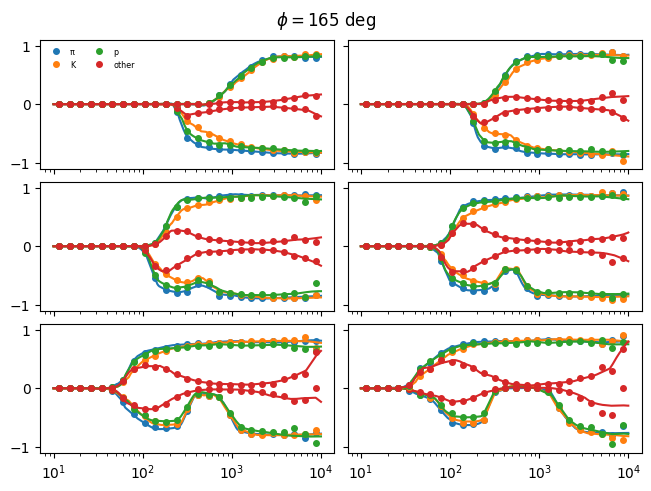

In [7]:
labels = ("π", "K", "p", "other")
for phii in rec.axes[2].centers:
    if phii < 0:
        continue
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
    plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
    for etai, axi in zip(rec.axes[0].centers, axes.flat):
        plt.sca(axi)
        for ich, charge in enumerate((-1, 1)):
            for isp, label in enumerate(labels):
                ma = X_raw[:, 0] == etai
                ma &= X_raw[:, 2] == np.cos(phii)
                ma &= X_raw[:, 3] == np.sin(phii)
                ma &= X_raw[:, 4] == ich
                ma &= X_raw[:, 5] == isp
                plt.plot(
                    np.exp(X_raw[ma, 1]),
                    charge * y[ma],
                    "o",
                    ms=4,
                    color=f"C{isp}",
                    label=f"{label}" if ich else None,
                )

                mpt = np.geomspace(10, 1e4, 2000)
                Xp = np.empty((len(mpt), 6), dtype=np.float32)
                Xp[:, 0] = etai
                Xp[:, 1] = np.log(mpt)
                Xp[:, 2] = np.cos(phii)
                Xp[:, 3] = np.sin(phii)
                Xp[:, 4] = ich
                Xp[:, 5] = isp
                yp = torch_model(torch.tensor(scaler.transform(Xp))).detach().numpy()
                plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
    plt.sca(axes[0, 0])
    plt.semilogx()
    plt.ylim(-1.1, 1.1)
    plt.legend(fontsize="xx-small", ncol=2, frameon=False)

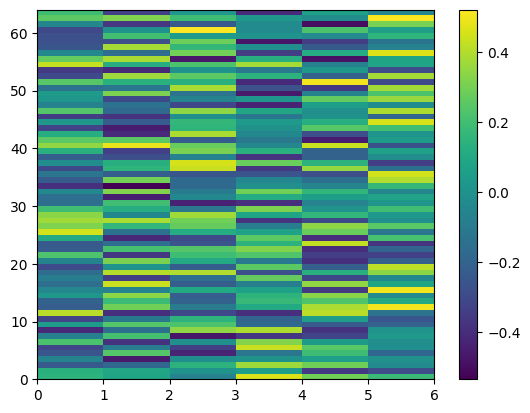

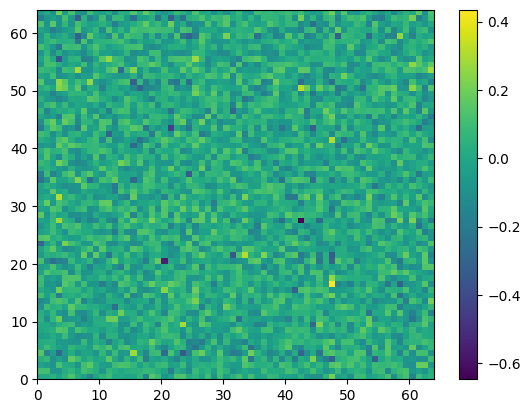

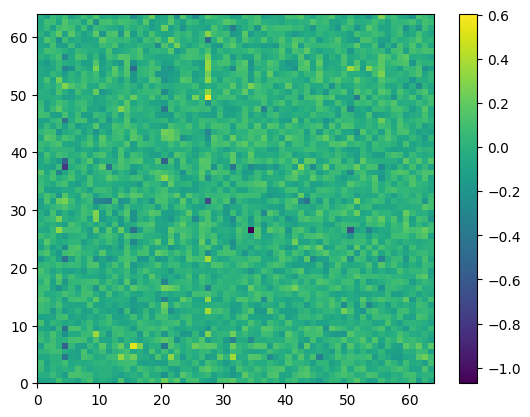

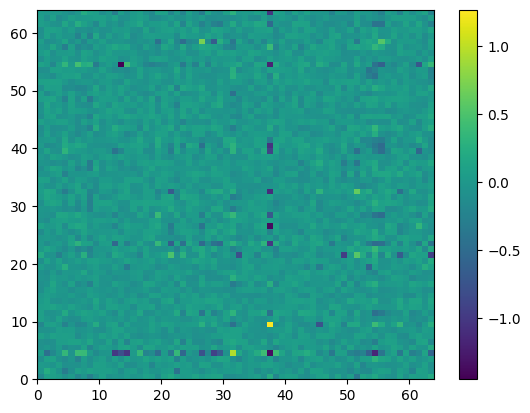

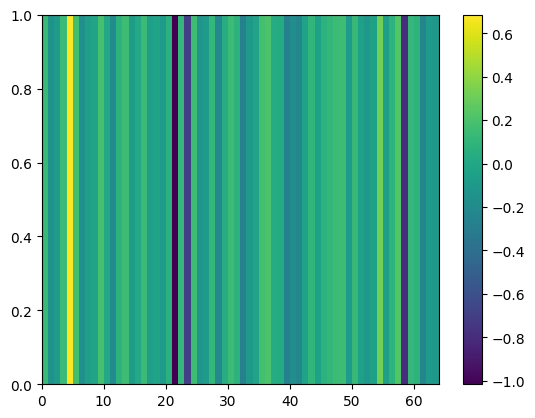

In [29]:
for par in torch_model.parameters():
    if len(par.shape) > 1:
        plt.figure()
        plt.pcolormesh(par.detach().numpy())
        plt.colorbar()

## Flax / JAX

JAX process: 0 / 1
JAX local devices: [CpuDevice(id=0)]
epoch 1 loss=0.5108487606048584
epoch 100 loss=0.004832323174923658
epoch 200 loss=0.0024893523659557104
epoch 300 loss=0.0017245868220925331
epoch 351 learning rate=0.00800000037997961
epoch 400 loss=0.0013178256340324879
epoch 462 learning rate=0.006400000303983688
epoch 500 loss=0.0011643833713606
epoch 577 learning rate=0.005120000336319208
epoch 600 loss=0.0010619960958138108
epoch 700 loss=0.000996587797999382
epoch 718 learning rate=0.0040960004553198814
epoch 800 loss=0.0009406638564541936
epoch 900 loss=0.0009115184075199068
epoch 903 learning rate=0.0032768005039542913
epoch 1000 loss=0.0008621664601378143
epoch 1100 loss=0.0008274626452475786
epoch 1177 learning rate=0.002621440449729562
epoch 1200 loss=0.0007958646165207028
epoch 1300 loss=0.000772734871134162
epoch 1353 learning rate=0.002097152406349778
epoch 1400 loss=0.0007518930360674858
epoch 1500 loss=0.0007351365056820214
epoch 1600 loss=0.0007137712673284113
e

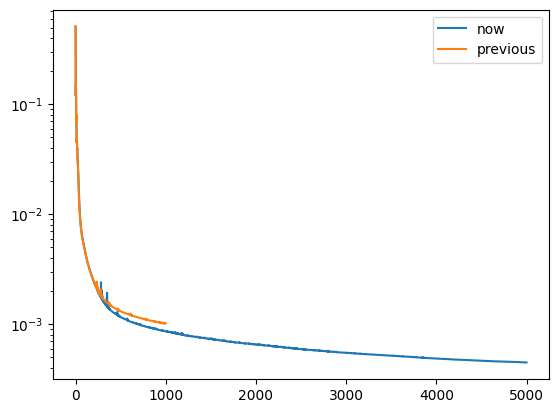

In [97]:
from typing import Callable, Iterable
from ml_collections import ConfigDict
import jax
from jax import numpy as jnp
from flax import linen as nn
import optax


class Model(nn.Module):
    sizes: Iterable[int]  # Number of hidden neurons
    nonlin: Callable

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        for size in self.sizes:
            x = nn.Dense(size)(x)
            x = self.nonlin(x)
        return nn.Dense(1)(x).flatten()


def train_and_evaluate(config: ConfigDict, inputs, outputs):
    model = Model(config.layers, config.nonlin)

    @jax.jit
    def loss_fn(params, inputs, outputs):
        y_pred = model.apply(params, inputs)
        return jnp.mean(jnp.square(y_pred - outputs))

    key1, key2, key3 = jax.random.split(jax.random.PRNGKey(0), num=3)
    params = model.init(key2, jax.random.normal(key1, inputs.shape[1:]))

    tx = optax.inject_hyperparams(optax.adabelief)(learning_rate=config.learning_rate)
    state = tx.init(params)
    loss_grad_fn = jax.value_and_grad(loss_fn)

    losses = []
    prev_loss = np.inf
    epochs_without_improvement = 0
    for epoch in range(1, config.max_epoch + 1):

        loss, grads = loss_grad_fn(params, inputs, outputs)
        updates, state = tx.update(grads, state)
        params = optax.apply_updates(params, updates)

        losses.append(loss)

        if epoch == 1 or epoch % config.print_freq == 0:
            print(f"epoch {epoch} loss={loss}")

        if loss < prev_loss:
            epochs_without_improvement = 0
            prev_loss = loss
        else:
            epochs_without_improvement += 1
        if epochs_without_improvement >= config.shrink_patience:
            state.hyperparams["learning_rate"] *= config.learning_rate_shrink_factor
            print(f"epoch {epoch } learning rate={state.hyperparams['learning_rate']}")
            epochs_without_improvement = 0
            continue
        if state.hyperparams["learning_rate"] < config.tolerance:
            break

    return model, params, losses

print(f"JAX process: {jax.process_index()} / {jax.process_count()}")
print(f"JAX local devices: {jax.local_devices()}")

config = ConfigDict()
config.layers = (2 ** 6,) * 4
config.nonlin = nn.leaky_relu
config.max_epoch = 5000
config.learning_rate = 1e-2
config.shrink_patience = 10
config.learning_rate_shrink_factor = 0.8
config.print_freq = 100
config.tolerance = 1e-6

prev_losses = losses

flax_model, flax_params, losses = train_and_evaluate(config, X, y)

plt.plot(losses, label="now")
plt.plot(prev_losses, label="previous")
plt.legend()
plt.semilogy();

In [98]:
print("MLPRegressor", mean_squared_error(clf.predict(X), y))
print("PyTorch     ", mean_squared_error(torch_model(torch_X).detach().numpy(), y))
print("Flax        ", mean_squared_error(flax_model.apply(flax_params, X), y))

MLPRegressor 0.0010236062
PyTorch      0.0006794772
Flax         0.0004482363


In [99]:
n = 0
for layer in flax_params["params"].values():
    n += np.prod(layer["kernel"].shape) + layer["bias"].shape[0]
print("number of parameters", n)

number of parameters 12993


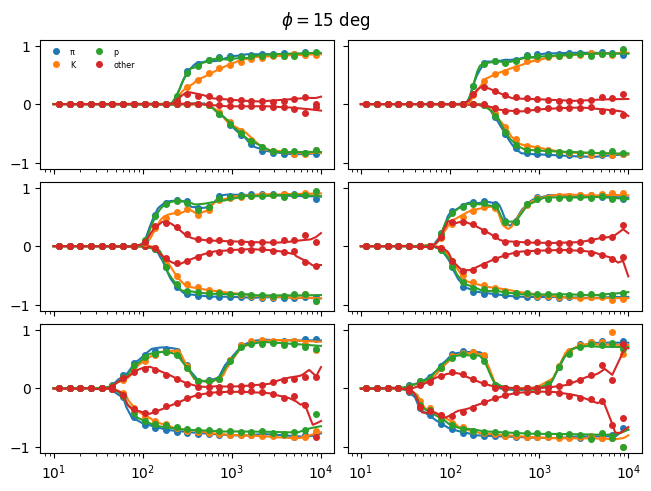

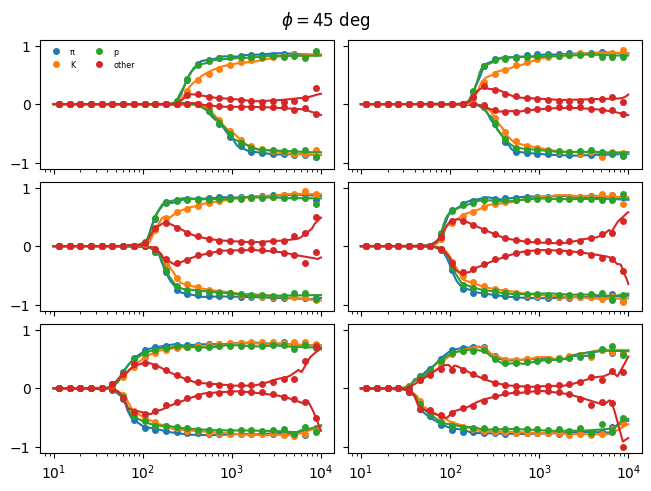

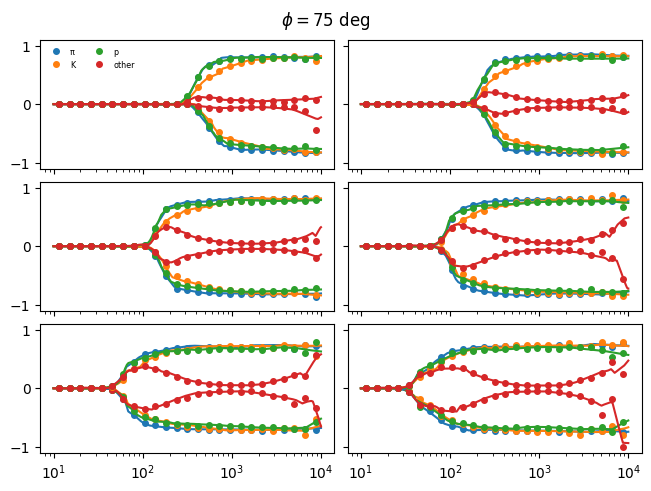

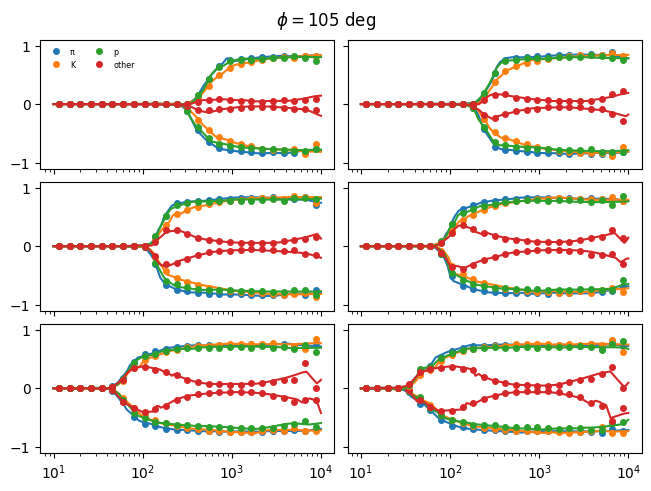

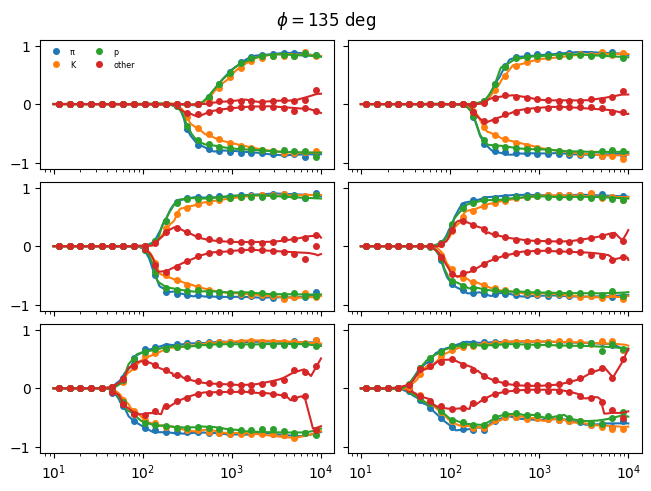

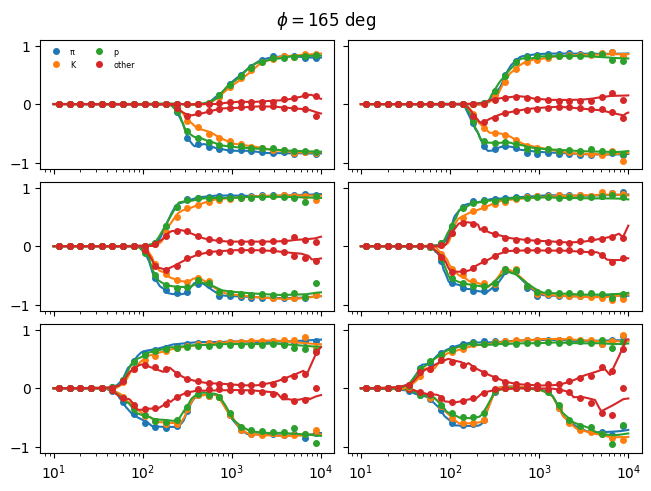

In [100]:
labels = ("π", "K", "p", "other")
for phii in rec.axes[2].centers:
    if phii < 0:
        continue
    fig, axes = plt.subplots(3, 2, sharex=True, sharey=True, layout="compressed")
    plt.suptitle(rf"$\phi = {np.degrees(phii):.0f}$ deg")
    for etai, axi in zip(rec.axes[0].centers, axes.flat):
        plt.sca(axi)
        for ich, charge in enumerate((-1, 1)):
            for isp, label in enumerate(labels):
                ma = X_raw[:, 0] == etai
                ma &= X_raw[:, 2] == np.cos(phii)
                ma &= X_raw[:, 3] == np.sin(phii)
                ma &= X_raw[:, 4] == ich
                ma &= X_raw[:, 5] == isp
                plt.plot(
                    np.exp(X_raw[ma, 1]),
                    charge * y[ma],
                    "o",
                    ms=4,
                    color=f"C{isp}",
                    label=f"{label}" if ich else None,
                )

                mpt = np.geomspace(10, 1e4, 2000)
                Xp = np.empty((len(mpt), 6), dtype=np.float32)
                Xp[:, 0] = etai
                Xp[:, 1] = np.log(mpt)
                Xp[:, 2] = np.cos(phii)
                Xp[:, 3] = np.sin(phii)
                Xp[:, 4] = ich
                Xp[:, 5] = isp
                yp = flax_model.apply(flax_params, scaler.transform(Xp))
                plt.plot(np.exp(Xp[:, 1]), charge * yp, color=f"C{isp}")
    plt.sca(axes[0, 0])
    plt.semilogx()
    plt.ylim(-1.1, 1.1)
    plt.legend(fontsize="xx-small", ncol=2, frameon=False)

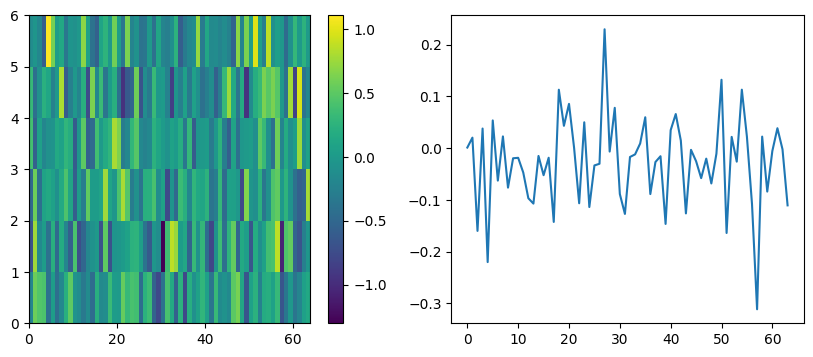

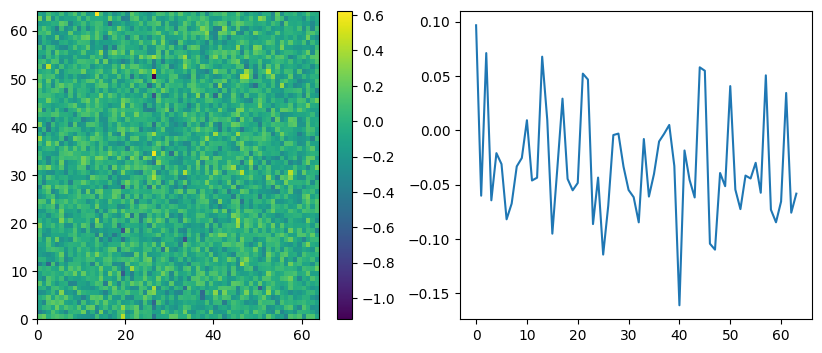

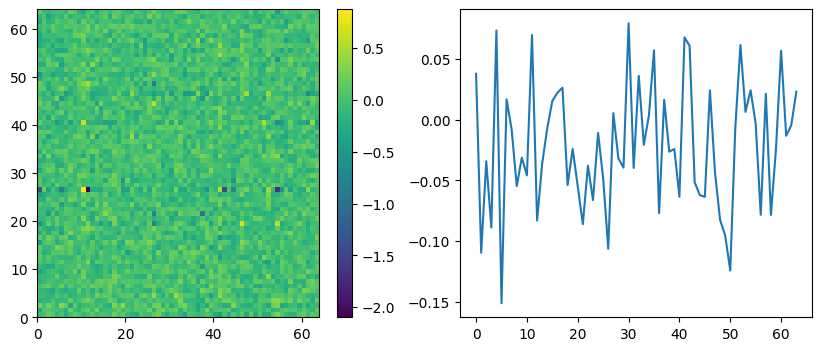

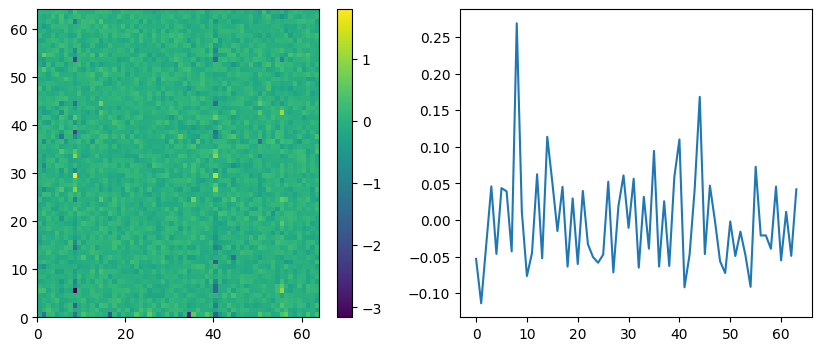

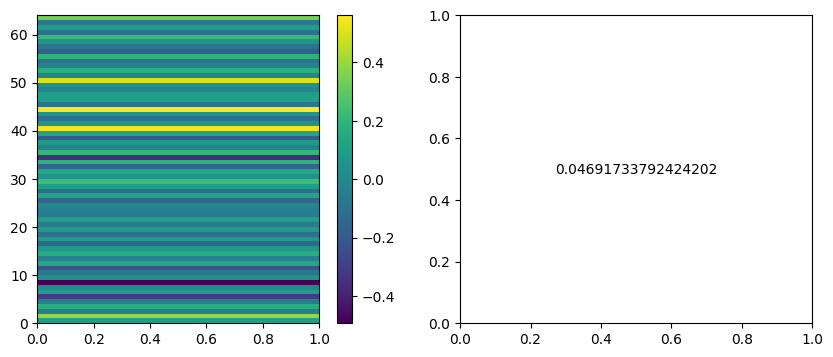

In [101]:
for layer in flax_params["params"].values():
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    plt.sca(ax[0])
    plt.pcolormesh(layer["kernel"])
    plt.colorbar()
    if layer["bias"].shape == (1,):
        ax[1].text(0.5, 0.5, f"{layer['bias'][0]}", ha="center", va="center")
    else:
        ax[1].plot(layer["bias"])
